<a href="https://colab.research.google.com/github/perrin-isir/tp_classif_images/blob/main/tp_classif_images.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>
<a id="raw-url" href="https://raw.githubusercontent.com/perrin-isir/tp_classif_images/main/tp_classif_images.ipynb" download> <img align="left" src="https://img.shields.io/badge/Github-Download%20(Right%20click%20%2B%20Save%20link%20as...)-blue" alt="Download (Right click + Save link as)" title="Download Notebook"></a>

**IMPORTANT :** Ce notebook fonctionne mieux avec accélération GPU.  
Dans Colab : dans le menu Colab, choisissez Runtime > Change Runtime Type, puis sélectionnez 'GPU'.

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
from PIL import ImageFile
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

print("Using device: ", device)

learning_rate = 0.01
momentum = 0.5
batch_size_train = 40
batch_size_test = 500

Using device:  mps


In [2]:
tmp_dir = os.path.join(os.path.expanduser("~"), "tmp_data")
# save dataset zip file in /root/tmp_data/, and unzip data
if not os.path.isfile(os.path.join(os.path.expanduser("~"), "tmp_data", "dataset.zip")):
    !mkdir {os.path.join(os.path.expanduser("~"), "tmp_data")}
    !wget -P {tmp_dir} -O {os.path.join(os.path.expanduser("~"), "tmp_data", "dataset.zip")} "https://filesender.renater.fr/download.php?token=c4814b83-d7fb-48df-9dec-0672109b65a0&files_ids=47151538"
    !unzip --qq -d {os.path.join(os.path.expanduser("~"), "tmp_data")} {os.path.join(os.path.expanduser("~"), "tmp_data", "dataset.zip")}

--2024-12-20 13:02:41--  https://filesender.renater.fr/download.php?token=c4814b83-d7fb-48df-9dec-0672109b65a0&files_ids=47151538
Résolution de filesender.renater.fr (filesender.renater.fr)… 194.57.3.10
Connexion à filesender.renater.fr (filesender.renater.fr)|194.57.3.10|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 262152450 (250M) [application/zip]
Sauvegarde en : « /Users/unie/tmp_data/dataset.zip »

dataset.zip         100%[===================>] 250,01M  4,05MB/s    ds 73s     

2024-12-20 13:03:54 (3,45 MB/s) — « /Users/unie/tmp_data/dataset.zip » sauvegardé [262152450/262152450]



In [3]:
# dataloader class and function

ImageFile.LOAD_TRUNCATED_IMAGES = True


class Data:
    def __init__(self, dataset_train, dataset_train_original, dataloader_train,
                 dataset_test, dataset_test_original, dataloader_test,
                 batch_size_train, batch_size_test):
        self.train = dataset_train
        self.train_original = dataset_train_original
        self.loader_train = dataloader_train
        self.num_train_samples = len(dataset_train)
        self.test = dataset_test
        self.test_original = dataset_test_original
        self.loader_test = dataloader_test
        self.num_test_samples = len(dataset_test)
        self.batch_size_train = batch_size_train
        self.batch_size_test = batch_size_test


def loadImgs(des_dir, img_size=100, batch_size_train=40, batch_size_test=100):

    dataset_train = dset.ImageFolder(root=os.path.join(des_dir, "train"),
                               transform=transforms.Compose([
                                   transforms.Resize(img_size),
                                   transforms.RandomCrop(75, padding=4),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x.to(device)),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                               ]))

    dataset_train_original = dset.ImageFolder(root=os.path.join(des_dir, "train"),
                               transform=transforms.Compose([
                                   transforms.Resize(img_size),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x.to(device)),
                               ]))

    dataset_test = dset.ImageFolder(root=os.path.join(des_dir, "test"),
                               transform=transforms.Compose([
                                   transforms.Resize(img_size),
                                   transforms.RandomCrop(75, padding=4),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x.to(device)),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                               ]))

    dataset_test_original = dset.ImageFolder(root=os.path.join(des_dir, "test"),
                               transform=transforms.Compose([
                                   transforms.Resize(img_size),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x.to(device)),
                               ]))

    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True)

    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=True)

    data = Data(dataset_train, dataset_train_original, dataloader_train,
                dataset_test, dataset_test_original, dataloader_test,
                batch_size_train, batch_size_test)
    return data

In [4]:
# plotting tool

def plotdata(data, indexes, model=None, original=True):
    l = []
    l_original = []
    for elt in indexes:
        t, _ = data.test[elt]
        l.append(t)
        tbis, _ = data.test_original[elt]
        l_original.append(tbis)
    cte = 30.0/9.0
    k = len(l)
    n = int(np.sqrt(cte * k))
    m = int(k/(n * 1.0))
    if (n*m<k):
        m = m+1
    width=20
    mult = 2
    if model is None:
        mult = 1
    fig, ax = plt.subplots(mult*m,n,squeeze=False, figsize=(width,int(width*m/(n*2.0))))
    for i in range(m):
        if model is not None:
            for j in range(n):
                if(j+n*i < k):
                    ax[mult*i+1,j].tick_params(axis=u'both', which=u'both',length=0)
                    ax[mult*i+1,j].set_ylim([-0.5,10.5])
                    ax[mult*i+1,j].set_xlim([-1.5,12.5])
                    ax[mult*i+1,j].set_xticks([])
                    ax[mult*i+1,j].set_xticks(np.arange(0.5,9.5,1), minor=True)
                    ax[mult*i+1,j].set_yticks([])
                    ax[mult*i+1,j].grid(False)
                    ax[mult*i+1,j].set_aspect('equal')
                    L = F.softmax(model(l[j+n*i]), dim=1).cpu().data.numpy().flatten()
                    C = [(0.9, 0.1, 0.0, 1.0), (0.0, 0.1, 0.9, 1.0)]
                    ax[mult*i+1,j].barh([1,5], [z * 10.0 for z in reversed(L)], color=C)
                    for idx in range(len(L)):
                        if L[idx]>0.02:
                            ax[mult*i+1,j].text(10.0*L[idx]+0.15,(len(L)-1-idx+0.1)*4.0,idx)
                else:
                    ax[mult*i+1,j].axis('off')
        # ------------------
        for j in range(n):
            if(j+n*i < k):
                ax[mult*i+0,j].tick_params(axis=u'both', which=u'both',length=0)
                ax[mult*i+0,j].set_xticks([])
                ax[mult*i+0,j].set_yticks([])
                ax[mult*i+0,j].grid(False)
                ax[mult*i+0,j].set_xticklabels([])
                ax[mult*i+0,j].set_yticklabels([])
                img = None
                if original:
                    img = l_original[j + n * i]
                else:
                    img = l[j + n * i]
                if img.shape[0] == 3:
                    N = img[:, :, :]
                    ax[mult * i + 0, j].imshow(N.permute(1, 2, 0).cpu().data.numpy(), )
                else:
                    N = img[0, :, :]
                    ax[mult*i+0,j].matshow(N.cpu().data.numpy(), cmap='Greys', )
            else:
                ax[mult*i+0,j].axis('off')
    return fig, ax

In [5]:
# evaluation on a batch of test data:

def evaluate(model, data):
    batch_enum = enumerate(data.loader_test)
    batch_idx, (testdata, testtargets) = next(batch_enum)
    testdata = testdata.to(device)
    testtargets = testtargets.to(device)
    model = model.eval()
    oupt = torch.argmax(model(testdata), dim=1)
    t = torch.sum(oupt == testtargets)
    result = t * 100.0 / len(testtargets)
    model = model.train()
    print(f"{t} correct on {len(testtargets)} ({result.item()} %)")
    return result.item()

In [6]:
# iterative training on batches for one epoch:

def train_epoch(model, optimizer, data):
    batch_enum = enumerate(data.loader_train)
    i_count = 0
    iterations = data.num_train_samples // data.batch_size_train
    for batch_idx, (dt, targets) in batch_enum:
        i_count = i_count+1
        outputs = model(dt.to(device))
        loss = F.cross_entropy(outputs, targets.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not i_count % 30:
            print(f"    batch {i_count} / {iterations}")
        if i_count == iterations:
            break

In [7]:
# define the neural net

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(((((75-2)//2-2)//2)**2)*64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x.view(-1, 3, 75, 75)))
        x = self.dropout1(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = self.dropout2(F.max_pool2d(x, 2))
        x = torch.flatten(x, 1)
        x = self.dropout3(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
print(((((75-2)//2-2)//2)**2)*64)

18496


In [9]:
896 + 18496 + 4735232 + 32896 + 258

4787778

In [10]:
# load the data

data = loadImgs(os.path.join(os.path.expanduser("~"), "tmp_data"), batch_size_train=batch_size_train, batch_size_test=batch_size_test)

In [11]:
# initialize the model

net = Net().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
# net.load_state_dict(torch.load(os.path.join(os.path.expanduser("~"), "tmp_data", "model_TP.pt")))


In [12]:
# evaluate the model on one batch of test data (expecting ~50% accuracy after initialization)
evaluate(net, data)

263 correct on 500 (52.599998474121094 %)


52.599998474121094

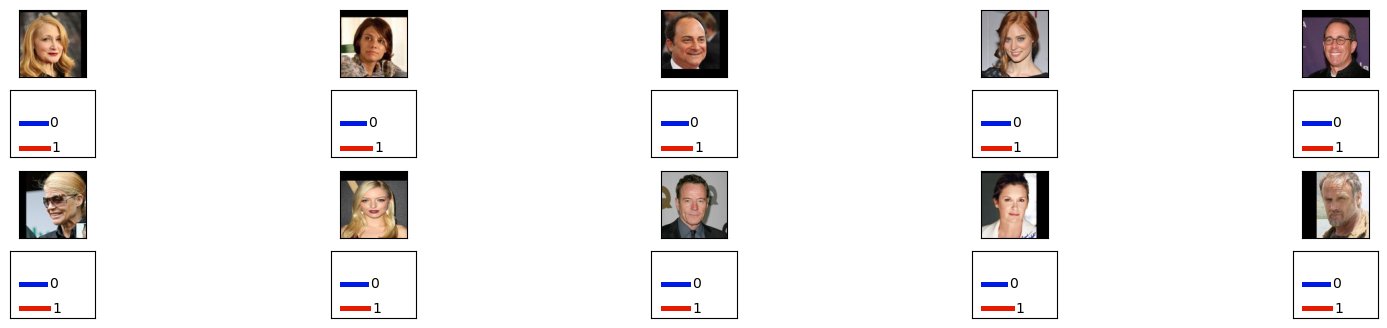

In [13]:
# plot results on random images from the test set

indices = np.random.choice(range(data.num_test_samples), 10)
fig, ax = plotdata(data, indices, net, original=True)

In [ ]:
# train for one epoch, and save the model
num_epochs = 5
for j in range(num_epochs):
    print(f"epoch {j+1} / {num_epochs}")
    train_epoch(net, optimizer, data)
    evaluate(net, data)
    torch.save(net.state_dict(), os.path.join(os.path.expanduser("~"), "tmp_data", "model_TP.pt"))

epoch 1 / 5
    batch 30 / 1000
    batch 60 / 1000
    batch 90 / 1000
    batch 120 / 1000
    batch 150 / 1000
    batch 180 / 1000
    batch 210 / 1000
    batch 240 / 1000
    batch 270 / 1000
    batch 300 / 1000
    batch 330 / 1000
    batch 360 / 1000
    batch 390 / 1000
    batch 420 / 1000
    batch 450 / 1000
    batch 480 / 1000
    batch 510 / 1000
    batch 540 / 1000
    batch 570 / 1000
    batch 600 / 1000
    batch 630 / 1000
    batch 660 / 1000
    batch 690 / 1000
    batch 720 / 1000
    batch 750 / 1000
    batch 780 / 1000
    batch 810 / 1000
    batch 840 / 1000
    batch 870 / 1000
    batch 900 / 1000
    batch 930 / 1000
    batch 960 / 1000
    batch 990 / 1000
304 correct on 500 (60.79999923706055 %)
epoch 2 / 5
    batch 30 / 1000
    batch 60 / 1000
    batch 90 / 1000
    batch 120 / 1000
    batch 150 / 1000
    batch 180 / 1000
    batch 210 / 1000


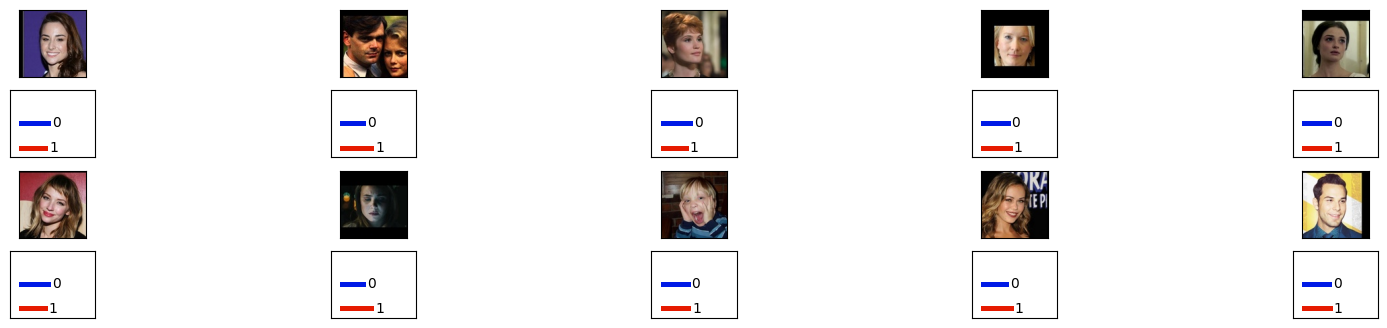

In [15]:
# plot results on random images from the test set

indices = np.random.choice(range(data.num_test_samples), 10)
fig, ax = plotdata(data, indices, net, original=True)

In [21]:
def train_loss_eval(data):
  """Évaluer la perte moyenne sur l'ensemble d'entraînement"""
  total_loss = 0
  total_batches = 0
  for batch_idx, (dt, targets) in enumerate(data.loader_train):
      outputs = net(dt.to(device))
      loss = F.cross_entropy(outputs, targets.to(device))
      total_loss += loss.item()
      total_batches += 1
  return total_loss / total_batches

In [22]:
train_losses=[]
test_accuracies=[]
num_epochs = 20  # Nombre d'epochs
for j in range(num_epochs):
    print(f"Epoch {j+1} / {num_epochs}")

    # Entraîner pour un epoch
    train_epoch(net, optimizer, data)

    # Évaluer la perte moyenne sur l'ensemble d'entraînement (optionnel)
    train_loss=train_loss_eval(data)
    train_losses.append(train_loss)

    # Évaluer la précision sur les données de test
    accuracy = evaluate(net, data)
    test_accuracies.append(accuracy)

Epoch 1 / 20
    batch 30 / 1000
    batch 60 / 1000
    batch 90 / 1000
    batch 120 / 1000
    batch 150 / 1000
    batch 180 / 1000
    batch 210 / 1000
    batch 240 / 1000
    batch 270 / 1000
    batch 300 / 1000
    batch 330 / 1000
    batch 360 / 1000
    batch 390 / 1000
    batch 420 / 1000
    batch 450 / 1000
    batch 480 / 1000
    batch 510 / 1000
    batch 540 / 1000
    batch 570 / 1000
    batch 600 / 1000
    batch 630 / 1000
    batch 660 / 1000
    batch 690 / 1000
    batch 720 / 1000
    batch 750 / 1000
    batch 780 / 1000
    batch 810 / 1000
    batch 840 / 1000
    batch 870 / 1000
    batch 900 / 1000
    batch 930 / 1000
    batch 960 / 1000
    batch 990 / 1000
304 correct on 500 (60.80000305175781 %)
Epoch 2 / 20
    batch 30 / 1000
    batch 60 / 1000
    batch 90 / 1000
    batch 120 / 1000
    batch 150 / 1000
    batch 180 / 1000
    batch 210 / 1000
    batch 240 / 1000
    batch 270 / 1000
    batch 300 / 1000
    batch 330 / 1000
    batch 360 /

In [99]:
evaluate(net, data)

400 correct on 500 (80.0 %)


80.0

### Affichage des accuracy de test et des loss d'entrainements

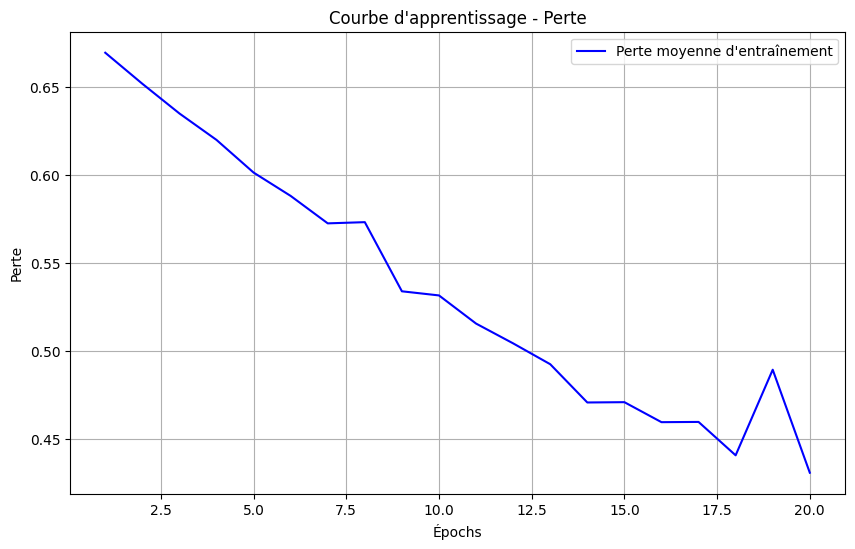

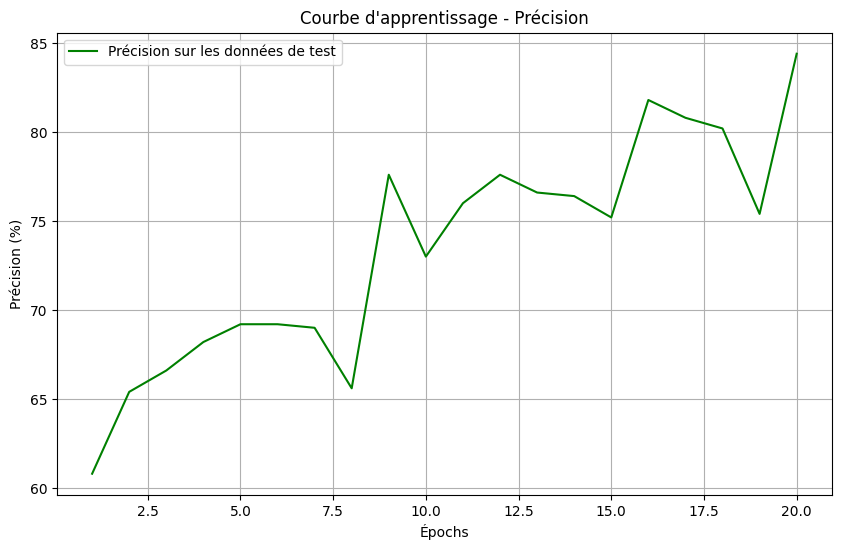

In [23]:
def plot_learning_curve(train_losses, test_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    # Courbe de perte
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Perte moyenne d'entraînement", color="blue")
    plt.xlabel("Épochs")
    plt.ylabel("Perte")
    plt.title("Courbe d'apprentissage - Perte")
    plt.legend()
    plt.grid()
    plt.show()

    # Courbe de précision
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, test_accuracies, label="Précision sur les données de test", color="green")
    plt.xlabel("Épochs")
    plt.ylabel("Précision (%)")
    plt.title("Courbe d'apprentissage - Précision")
    plt.legend()
    plt.grid()
    plt.show()

# Tracer les courbes après l'entraînement
plot_learning_curve(train_losses, test_accuracies, num_epochs)

### Affichage des accuracy de chaque classe

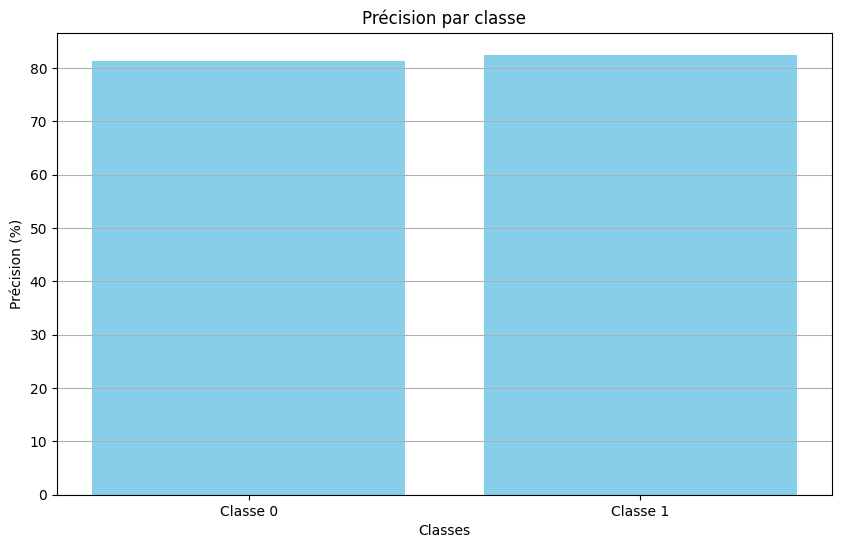

In [97]:
def calculate_class_accuracy(model, data):
    model.eval()
    class_correct = np.zeros(len(data.test.classes))
    class_total = np.zeros(len(data.test.classes))

    with torch.no_grad():
        for images, labels in data.loader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            for i in range(len(labels)):
                label = labels[i].item()
                if predictions[i].item() == label:
                    class_correct[label] += 1
                class_total[label] += 1

    class_accuracy = class_correct / class_total * 100
    return class_accuracy

def plot_class_accuracy(class_accuracy, class_names):
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_accuracy, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Précision (%)")
    plt.title("Précision par classe")
    plt.grid(axis="y")
    plt.show()

# Calculer et tracer les accuracy par classe
class_accuracy = calculate_class_accuracy(net, data)
plot_class_accuracy(class_accuracy, ['Classe 0', 'Classe 1'])

In [28]:
print(data.test.classes)

['20_26_test', '52_62_test']


### Visualisation des distributions de probabilité

In [25]:
import numpy as np

def evaluate_with_probabilities(model, data):
    model.eval()  # Mode évaluation
    all_probs = []  # Liste pour stocker les probabilités
    all_labels = []  # Liste pour stocker les labels réels

    with torch.no_grad():  # Pas besoin de calculer les gradients
        for images, labels in data.loader_test:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)  # Convertir les logits en probabilités
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Convertir en numpy arrays
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Calculer la moyenne et la variance des probabilités pour chaque classe
    results = {}
    for cls in range(all_probs.shape[1]):
        cls_probs = all_probs[all_labels == cls, cls]
        results[cls] = {
            "mean": np.mean(cls_probs),
            "variance": np.var(cls_probs),
            "values": cls_probs
        }

    return results

In [26]:
results = evaluate_with_probabilities(net, data)

print("Statistiques des probabilités par classe :")
for cls, stats in results.items():
    print(f"Classe {cls} :")
    print(f"  Moyenne des probabilités : {stats['mean']:.4f}")
    print(f"  Variance des probabilités : {stats['variance']:.4f}")

Statistiques des probabilités par classe :
Classe 0 :
  Moyenne des probabilités : 0.7198
  Variance des probabilités : 0.0498
Classe 1 :
  Moyenne des probabilités : 0.7252
  Variance des probabilités : 0.0513


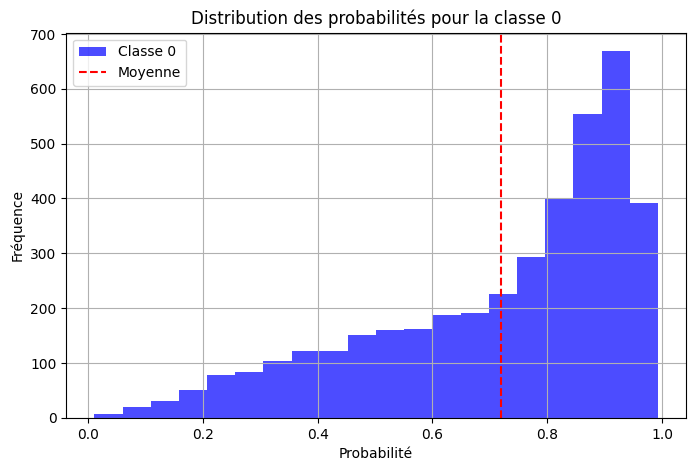

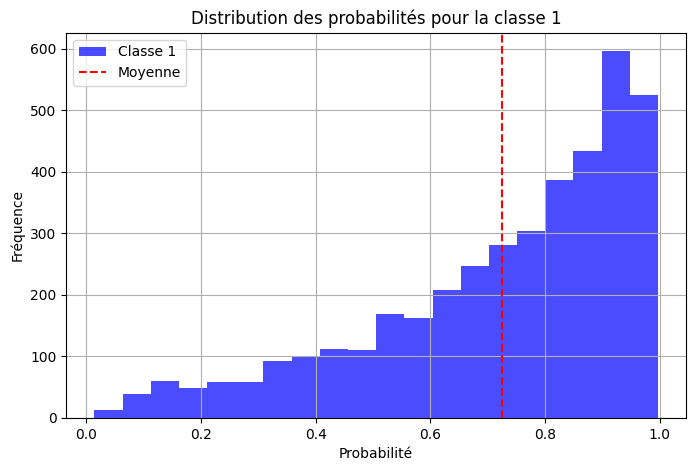

In [27]:
def plot_probability_distributions(results):
    for cls, stats in results.items():
        plt.figure(figsize=(8, 5))
        plt.hist(stats['values'], bins=20, alpha=0.7, color='blue', label=f"Classe {cls}")
        plt.axvline(stats['mean'], color='red', linestyle='--', label='Moyenne')
        plt.title(f"Distribution des probabilités pour la classe {cls}")
        plt.xlabel("Probabilité")
        plt.ylabel("Fréquence")
        plt.legend()
        plt.grid()
        plt.show()

# Visualiser les distributions des probabilités
plot_probability_distributions(results)

### Utilisation des crops pour tenter d'améliorer la classification

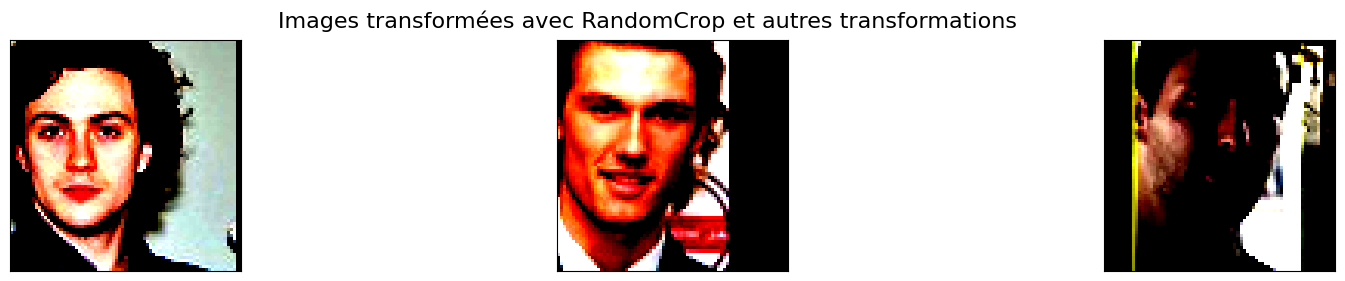

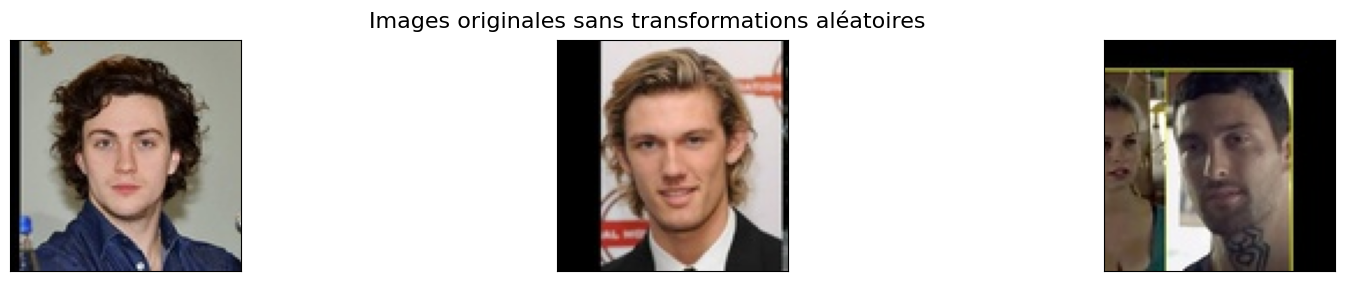

In [114]:
# Indices des images à visualiser
indices_to_visualize = [0, 10, 20]  # Choisissez des indices spécifiques du dataset

# Visualiser les images transformées (original=False applique les transformations)
fig, ax = plotdata(data, indices_to_visualize, model=None, original=False)
plt.suptitle("Images transformées avec RandomCrop et autres transformations", fontsize=16)
plt.show()

# Visualiser les images originales (original=True pour afficher sans transformations aléatoires)
fig, ax = plotdata(data, indices_to_visualize, model=None, original=True)
plt.suptitle("Images originales sans transformations aléatoires", fontsize=16)
plt.show()

In [100]:
def evaluate_multicrop(model, data, crops=5):
    """
    Evaluates the model using test-time augmentation (TTA) with multiple crops.

    Args:
        model: The trained model to evaluate.
        data: The Data object containing the test dataloader.
        num_crops: Number of crops to perform for each image.

    Returns:
        result (float): Accuracy percentage.
    """
    model = model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for testdata, testtargets in data.loader_test:
            testdata = testdata.to(device)
            testtargets = testtargets.to(device)
            batch_size = testdata.size(0)

            cumulative_predictions = torch.zeros(batch_size, len(data.test.classes), device=device)

            for _ in range(crops):
                augmented_data = transforms.Compose([
                    transforms.RandomCrop(75, padding=4),
                    transforms.RandomHorizontalFlip(),
                ])(testdata)

                outputs = model(augmented_data)
                cumulative_predictions += torch.softmax(outputs, dim=1)

            averaged_predictions = cumulative_predictions / crops
            predicted_labels = torch.argmax(averaged_predictions, dim=1)

            total_correct += torch.sum(predicted_labels == testtargets)
            total_samples += len(testtargets)

    accuracy = total_correct * 100.0 / total_samples
    print(f"{total_correct} correct on {total_samples} ({accuracy.item()} %)")
    return accuracy.item()


In [108]:
crop_nb =  np.arange(1, 15)
accuracies = []

for crop in crop_nb:
    print(f"### Crop number = {crop}")
    accuracies.append(evaluate_multicrop(net, data, crops=crop))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
### Crop number = 1
6504 correct on 8000 (81.30000305175781 %)
### Crop number = 2
6558 correct on 8000 (81.97500610351562 %)
### Crop number = 3
6530 correct on 8000 (81.62500762939453 %)
### Crop number = 4
6567 correct on 8000 (82.0875015258789 %)
### Crop number = 5
6589 correct on 8000 (82.36250305175781 %)
### Crop number = 6
6579 correct on 8000 (82.23750305175781 %)
### Crop number = 7
6585 correct on 8000 (82.31250762939453 %)
### Crop number = 8
6559 correct on 8000 (81.98750305175781 %)
### Crop number = 9
6609 correct on 8000 (82.61250305175781 %)
### Crop number = 10
6557 correct on 8000 (81.9625015258789 %)
### Crop number = 11
6559 correct on 8000 (81.98750305175781 %)
### Crop number = 12
6574 correct on 8000 (82.17500305175781 %)
### Crop number = 13
6598 correct on 8000 (82.47500610351562 %)
### Crop number = 14
6586 correct on 8000 (82.32500457763672 %)


In [109]:
def plot_crop_effects(crop_nb, accuracies):
    epochs = range(1, num_epochs + 1)

    # Courbe de perte
    plt.figure(figsize=(10, 6))
    plt.plot(crop_nb, accuracies, label="Accuracy", color="blue")
    plt.xlabel("Crops")
    plt.ylabel("Accuracy")
    plt.title("Accuracy par rapport au nombre de crop utilisé par image")
    plt.legend()
    plt.grid()
    plt.show()

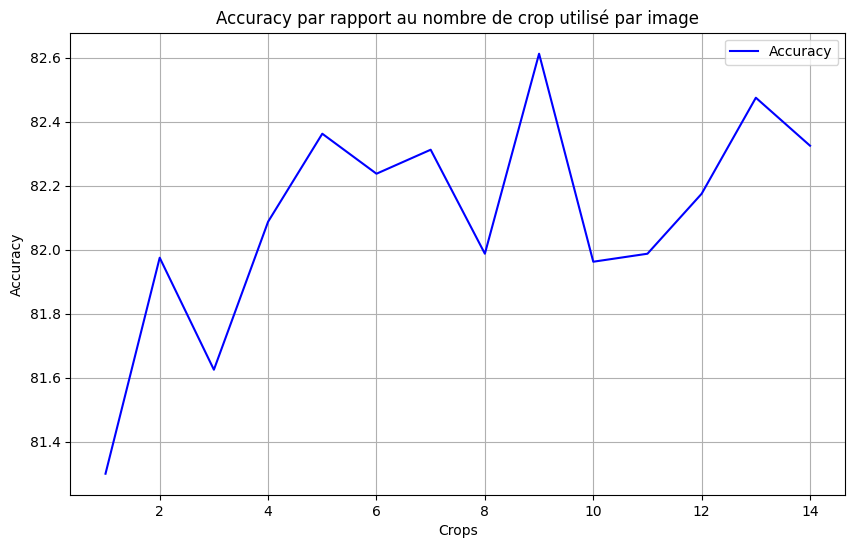

In [110]:
plot_crop_effects(crop_nb, accuracies)

In [1]:
# Q9

def find_class_misclassified_and_confident(data, model, target_class, confidence_threshold=0.9):
    """
    Trouve les indices des images mal classées et celles correctement classées avec forte confiance pour une classe cible.

    :param data: Objet contenant les données de test (data.loader_test)
    :param model: Modèle entraîné
    :param target_class: Classe cible à analyser (0 ou 1)
    :param confidence_threshold: Seuil de confiance pour les prédictions correctes
    :return: Listes des indices des mal classées et des correctement classées avec forte confiance
    """
    model.eval()  # Mettre le modèle en mode évaluation
    misclassified_indices = []
    confident_correct_indices = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(data.loader_test):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            probabilities = torch.softmax(outputs, dim=1)

            for i in range(len(labels)):
                global_idx = batch_idx * data.batch_size_test + i  # Calculer l'indice global
                # Filtrer uniquement les images de la classe cible
                if labels[i] == target_class:
                    # Si le modèle se trompe complètement
                    if predictions[i] != labels[i]:
                        misclassified_indices.append(global_idx)
                    # Si le modèle est correct et très confiant
                    elif predictions[i] == labels[i] and probabilities[i, predictions[i]] > confidence_threshold:
                        confident_correct_indices.append(global_idx)

    return misclassified_indices, confident_correct_indices

# Trouver les indices pour la classe 0
misclassified_0, confident_correct_0 = find_class_misclassified_and_confident(data, net, target_class=0)
# Trouver les indices pour la classe 1
misclassified_1, confident_correct_1 = find_class_misclassified_and_confident(data, net, target_class=1)

# Afficher les images mal classées pour la classe 0
print("Images mal classées pour la classe 0 :")
fig, ax = plotdata(data, misclassified_0[:10], model=None, original=True)
plt.suptitle("Images mal classées pour la classe 0", fontsize=16)
plt.show()

# Afficher les images correctement classées avec forte confiance pour la classe 0
print("Images correctement classées avec forte confiance pour la classe 0 :")
fig, ax = plotdata(data, confident_correct_0[:10], model=None, original=True)
plt.suptitle("Images correctement classées avec forte confiance pour la classe 0", fontsize=16)
plt.show()

# Afficher les images mal classées pour la classe 1
print("Images mal classées pour la classe 1 :")
fig, ax = plotdata(data, misclassified_1[:10], model=None, original=True)
plt.suptitle("Images mal classées pour la classe 1", fontsize=16)
plt.show()

# Afficher les images correctement classées avec forte confiance pour la classe 1
print("Images correctement classées avec forte confiance pour la classe 1 :")
fig, ax = plotdata(data, confident_correct_1[:10], model=None, original=True)
plt.suptitle("Images correctement classées avec forte confiance pour la classe 1", fontsize=16)
plt.show()

NameError: name 'data' is not defined

In [ ]:

def generate_image_for_class_with_evolution(
    model, target_class, input_image, lr=0.1, iterations=100, l2_weight=1e-3, display_interval=10
):
    """
    Génère une image pour une classe cible à partir d'une image du dataset, tout en affichant son évolution.

    :param model: Modèle PyTorch
    :param target_class: Classe cible à maximiser
    :param input_image: Image initiale issue du dataset
    :param lr: Learning rate pour l'optimisation
    :param iterations: Nombre total d'itérations
    :param l2_weight: Poids de la régularisation L2
    :param display_interval: Intervalle pour afficher les images
    :return: Image finale générée et son évolution
    """
    input_image = input_image.clone().detach().requires_grad_(True).to(device)
    optimizer = torch.optim.Adam([input_image], lr=lr)

    # Liste pour stocker les images à afficher
    evolution_images = []

    for i in range(iterations):
        optimizer.zero_grad()

        # Passer l'image générée dans le modèle
        output = model(input_image)
        class_score = output[0, target_class]  # Logit pour la classe cible

        # Ajouter une régularisation L2
        l2_loss = l2_weight * torch.norm(input_image)

        # Maximiser la sortie pour la classe cible
        loss = -class_score + l2_loss  # Gradient ascent

        # Rétropropagation et mise à jour
        loss.backward()
        optimizer.step()

        # Enregistrer l'image à intervalles réguliers
        if i % display_interval == 0 or i == iterations - 1:
            evolution_images.append(input_image.clone().detach().cpu())

    return input_image.detach(), evolution_images

def plot_evolution_grid(images, rows, cols, title="Évolution des images générées"):
    """
    Affiche une grille des images générées pour visualiser leur évolution.

    :param images: Liste des images
    :param rows: Nombre de lignes de la grille
    :param cols: Nombre de colonnes de la grille
    :param title: Titre de la figure
    """
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            img = images[i].squeeze(0).permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())  # Normaliser pour affichage
            ax.imshow(img)
            ax.set_title(f"Étape {i * 10}")
            ax.axis("off")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def generate_image_with_random_initialization(
    model, target_class, input_shape=(1, 3, 75, 75), lr=0.1, iterations=100, l2_weight=1e-3, display_interval=10
):
    """
    Génère une image pour une classe cible à partir d'une image aléatoire, avec affichage de l'évolution.

    :param model: Modèle PyTorch
    :param target_class: Classe cible à maximiser
    :param input_shape: Shape de l'image aléatoire (batch_size, channels, height, width)
    :param lr: Learning rate pour l'optimisation
    :param iterations: Nombre total d'itérations
    :param l2_weight: Poids de la régularisation L2
    :param display_interval: Intervalle pour afficher les images
    :return: Image finale générée et son évolution
    """
    # Initialiser une image aléatoire
    input_image = torch.randn(input_shape, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([input_image], lr=lr)

    # Liste pour stocker les images à afficher
    evolution_images = []

    for i in range(iterations):
        optimizer.zero_grad()

        # Passer l'image générée dans le modèle
        output = model(input_image)
        class_score = output[0, target_class]  # Logit pour la classe cible

        # Ajouter une régularisation L2
        l2_loss = l2_weight * torch.norm(input_image)

        # Maximiser la sortie pour la classe cible
        loss = -class_score + l2_loss  # Gradient ascent

        # Rétropropagation et mise à jour
        loss.backward()
        optimizer.step()

        # Enregistrer l'image à intervalles réguliers
        if i % display_interval == 0 or i == iterations - 1:
            evolution_images.append(input_image.clone().detach().cpu())

    return input_image.detach(), evolution_images

In [ ]:
# Obtenir une image du dataset
data_iter = iter(data.loader_train)
example_images, _ = next(data_iter)  # Prendre le premier batch
input_image = example_images[0].unsqueeze(0).to(device)  # Utiliser la première image du batch

# Générer une image pour une classe cible
target_class = 1  # Classe cible à maximiser
final_image, evolution_images = generate_image_for_class_with_evolution(
    net, target_class, input_image, lr=0.1, iterations=1000, l2_weight=1e-3, display_interval=10
)

# Afficher les images dans une grille
plot_evolution_grid(evolution_images, rows=2, cols=5, title="Évolution de l'image générée")

In [ ]:
final_image, evolution_images = generate_image_with_random_initialization(
    net, target_class, input_shape=(1, 3, 75, 75), lr=0.1, iterations=100, l2_weight=1e-3, display_interval=10
)

# Afficher les images dans une grille
plot_evolution_grid(evolution_images, rows=2, cols=5, title="Évolution de l'image générée (Image aléatoire)")